### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/v14.1_updated_ihd_cause/alabama/2023_05_24_18_03_09/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/v14.1_updated_ihd_cause/alabama/2023_05_24_18_03_09/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,25219.854894
1,25_to_29,female,2023,232,25233.577002
2,25_to_29,female,2023,357,25047.063655
3,25_to_29,female,2023,394,26883.986311
4,25_to_29,female,2023,602,26553.505818


In [5]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [6]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,779359.512778
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,787600.768383
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,753815.392804
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,735179.336925
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,739951.860151


In [7]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,779359.512778
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,787600.768383
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,753815.392804
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,735179.336925
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,739951.860151


In [8]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,781882.337100,765836.175331,823788.236735
1,25_to_29,female,2024,772996.566755,758332.575824,812846.958449
2,25_to_29,female,2025,765833.876223,753177.068876,805857.037724
3,25_to_29,female,2026,761100.605108,746241.691011,801640.718729
4,25_to_29,female,2027,757853.015232,742493.101735,800201.263671


In [9]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [10]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,female,2023,30.752369,30.731514,30.415758,31.030925
1,25_to_29,female,2024,30.739826,30.737573,30.422273,30.981614
2,25_to_29,female,2025,30.726972,30.733181,30.434151,30.957594
3,25_to_29,female,2026,30.726106,30.741062,30.446898,30.948010
4,25_to_29,female,2027,30.713061,30.718928,30.422406,30.966501


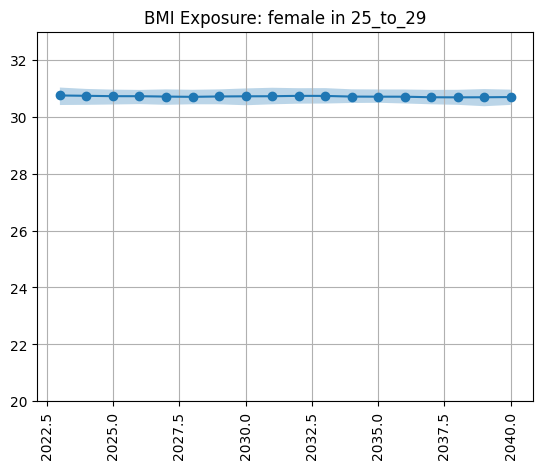

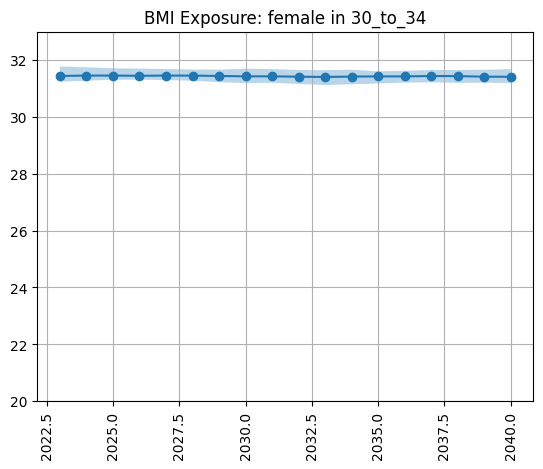

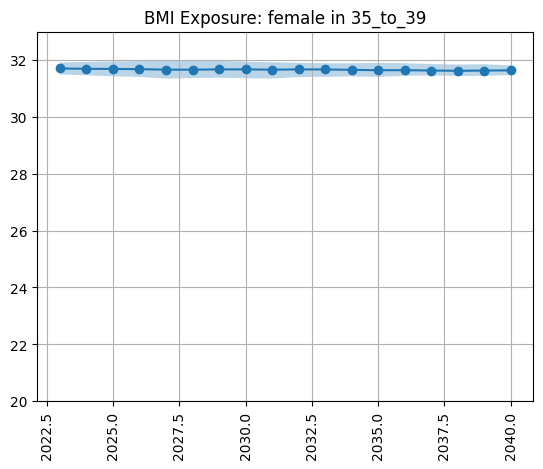

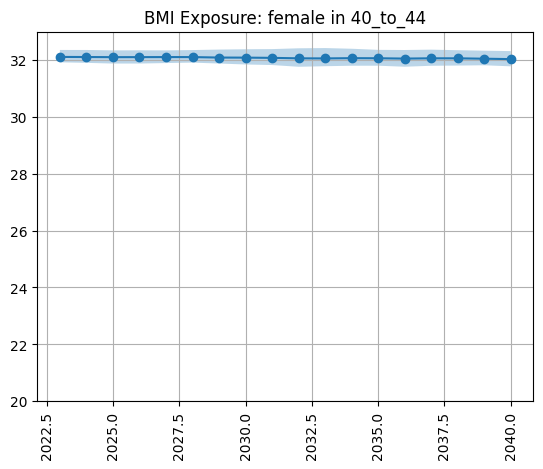

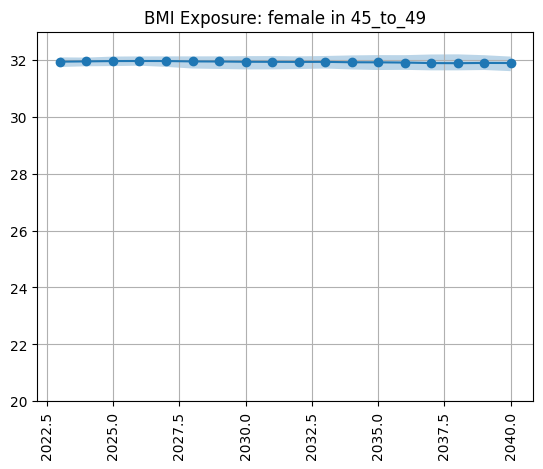

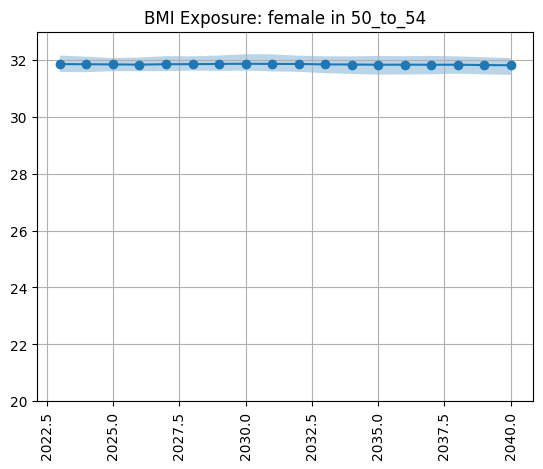

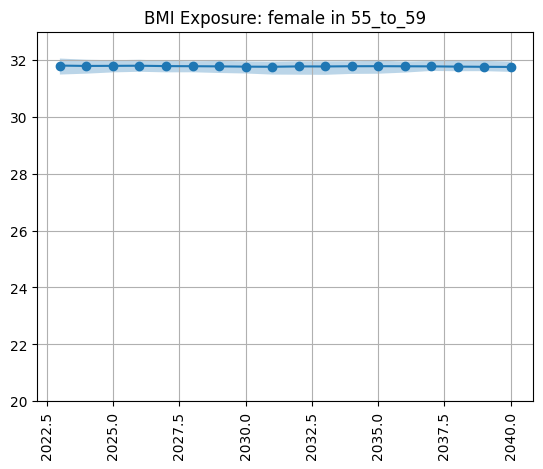

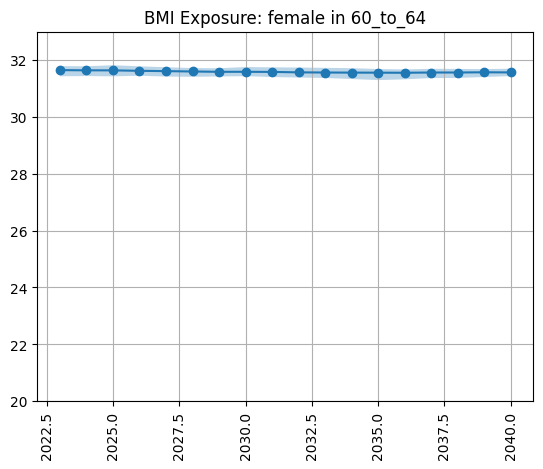

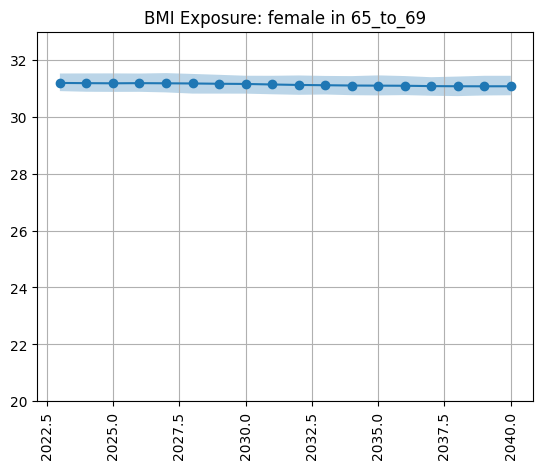

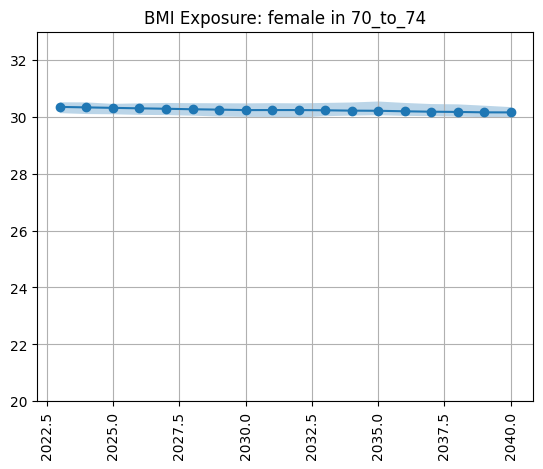

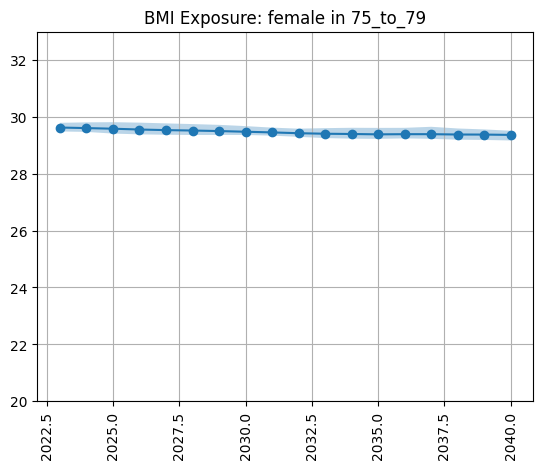

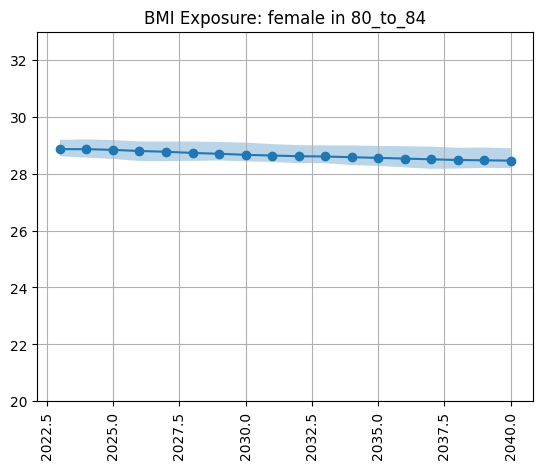

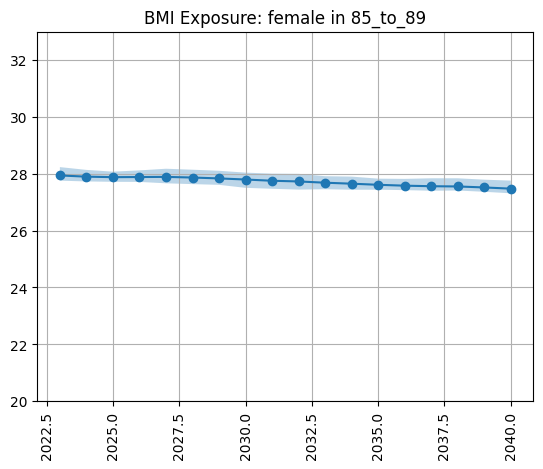

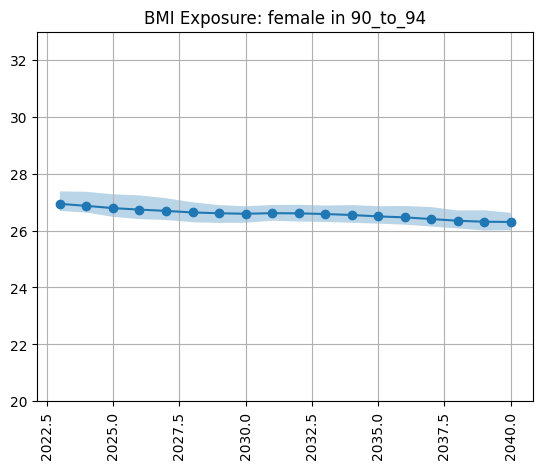

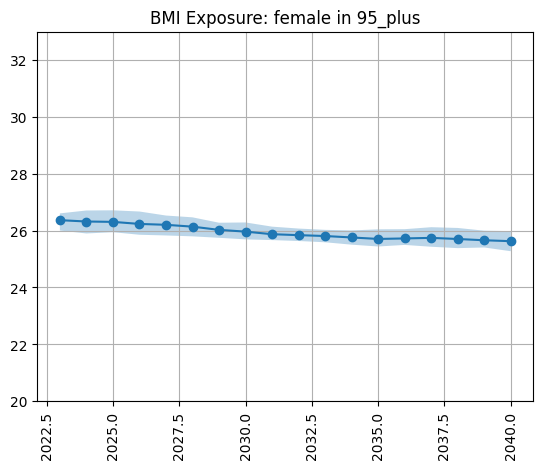

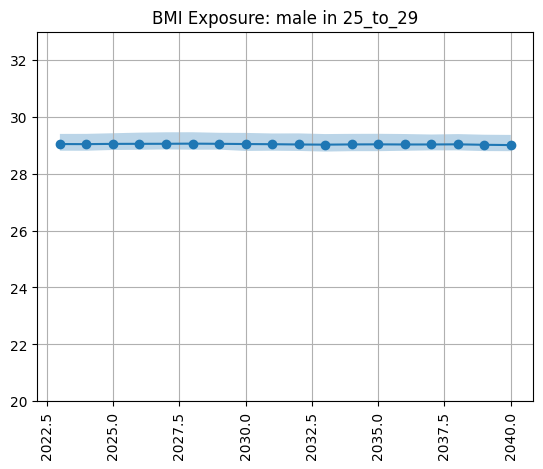

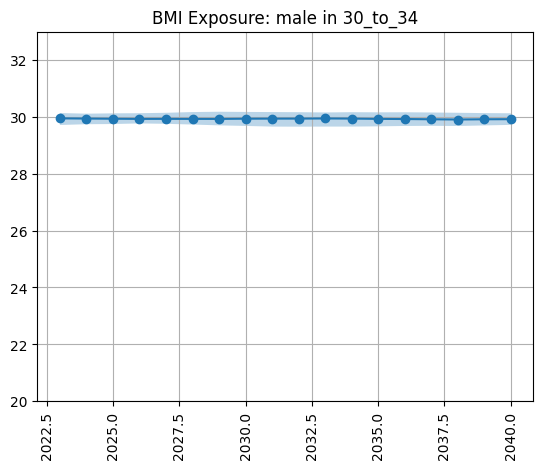

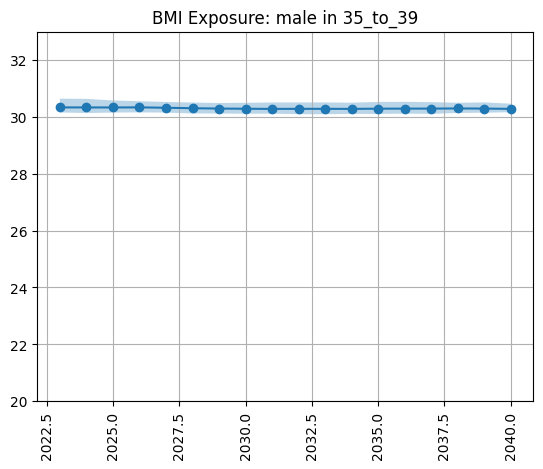

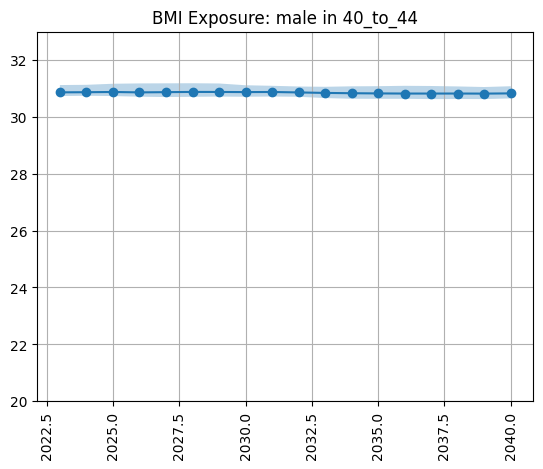

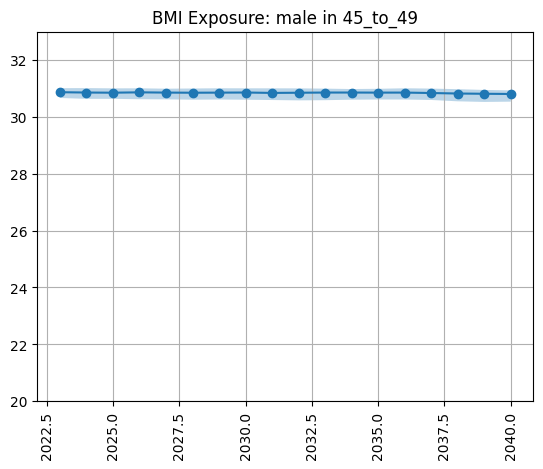

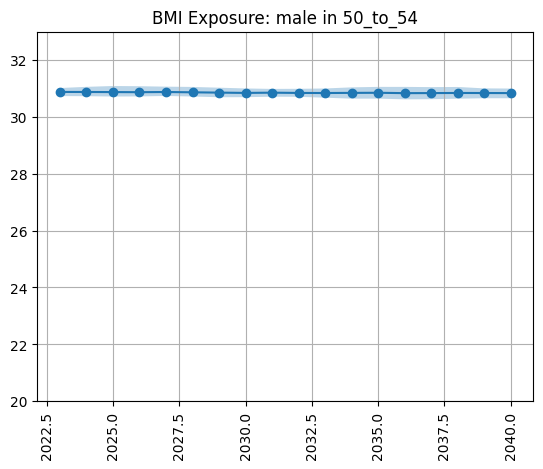

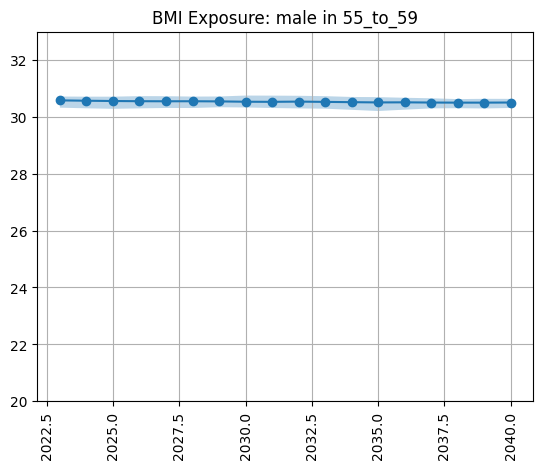

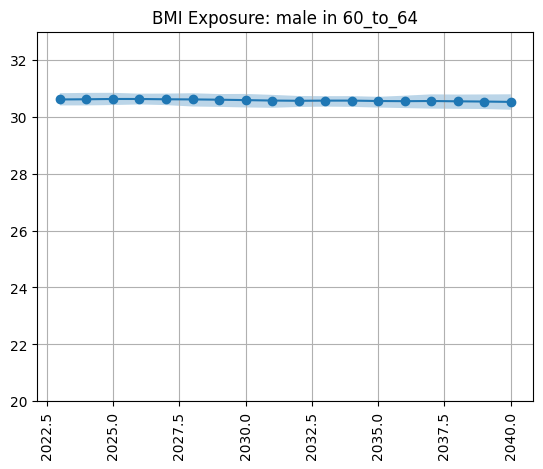

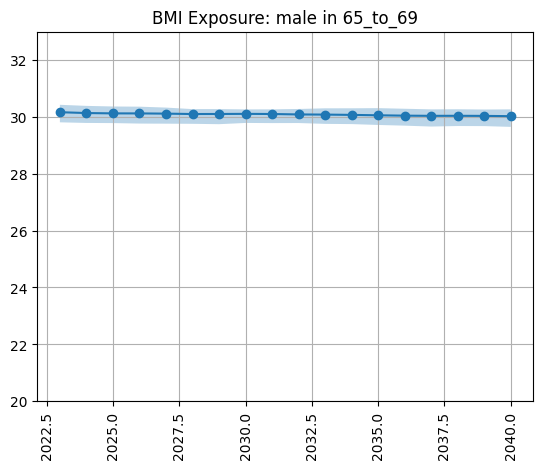

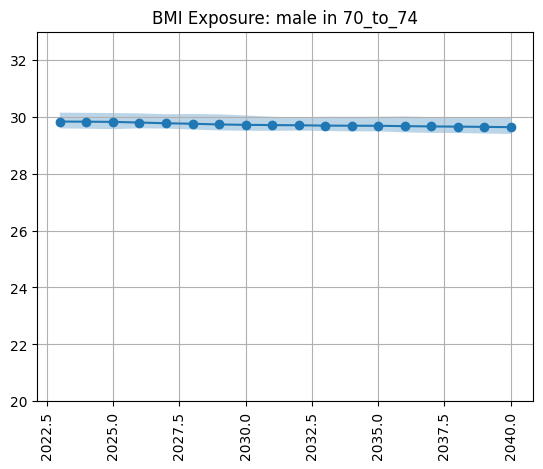

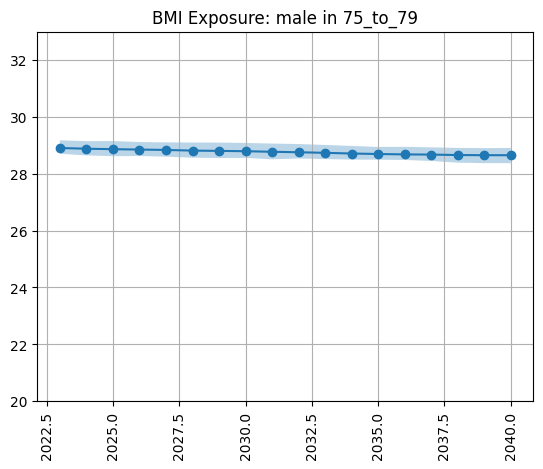

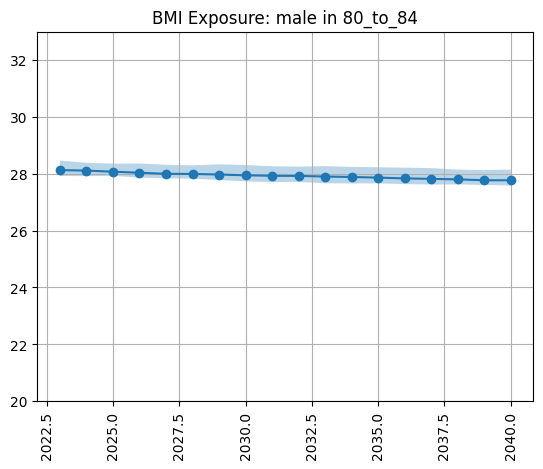

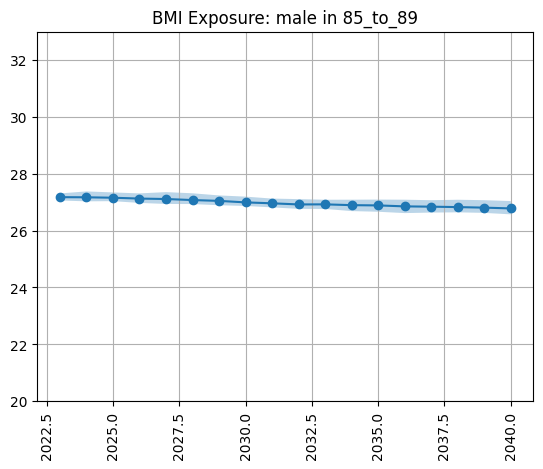

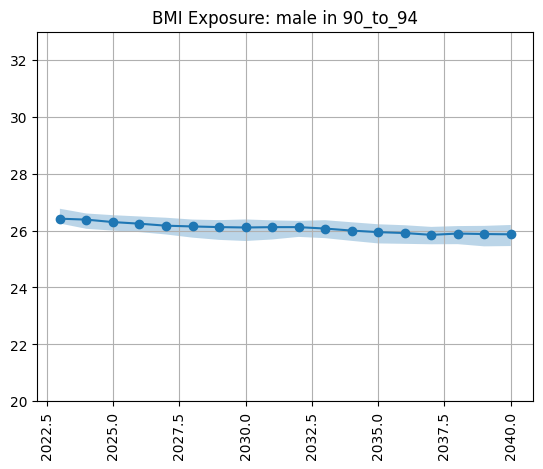

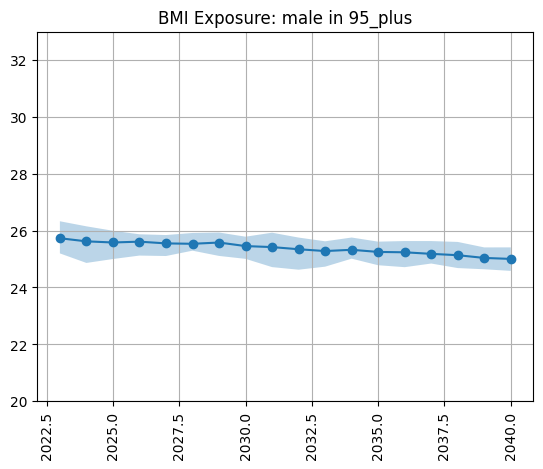

In [11]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [12]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,110.005755,107.834528,112.595255
1,25_to_29,female,2024,109.984129,107.817717,112.609756
2,25_to_29,female,2025,109.974656,107.846670,112.562170
3,25_to_29,female,2026,109.970649,107.887037,112.535751
4,25_to_29,female,2027,109.972751,107.878566,112.510742


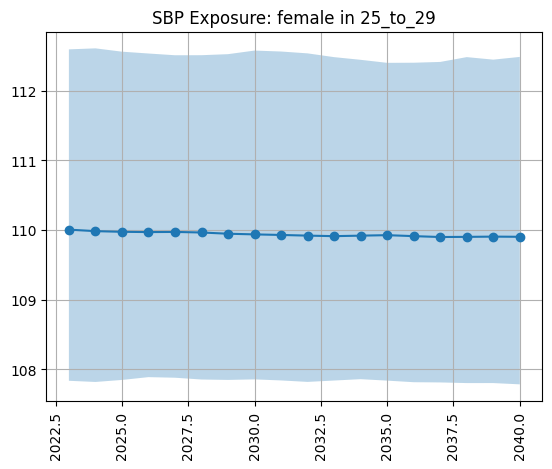

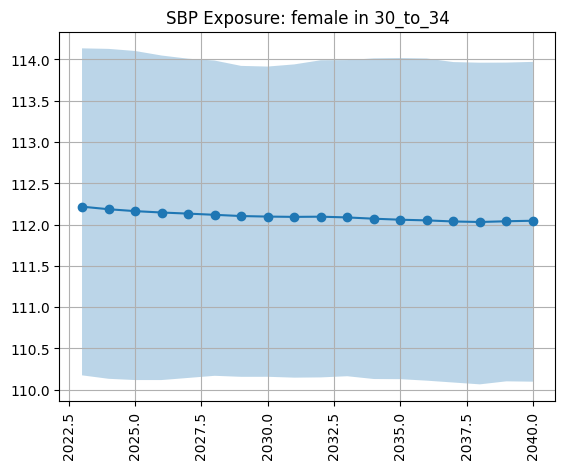

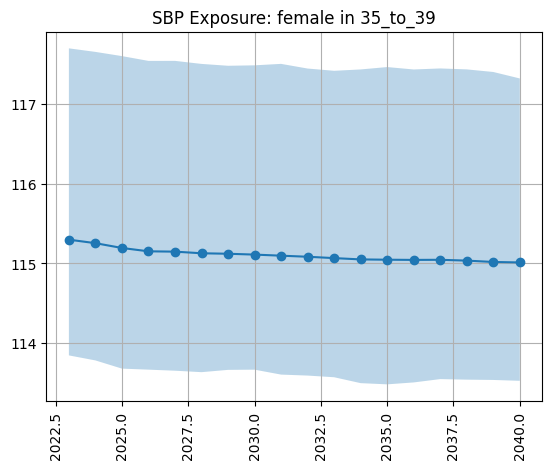

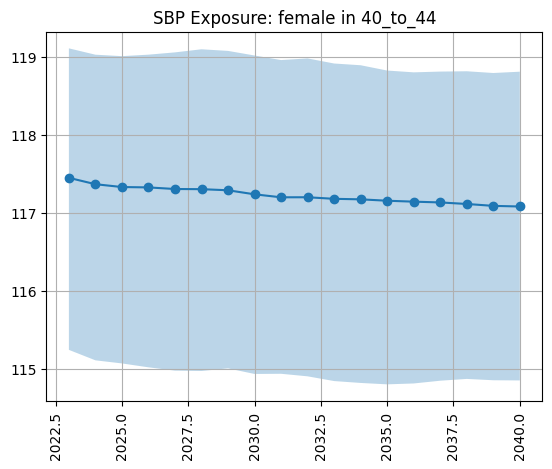

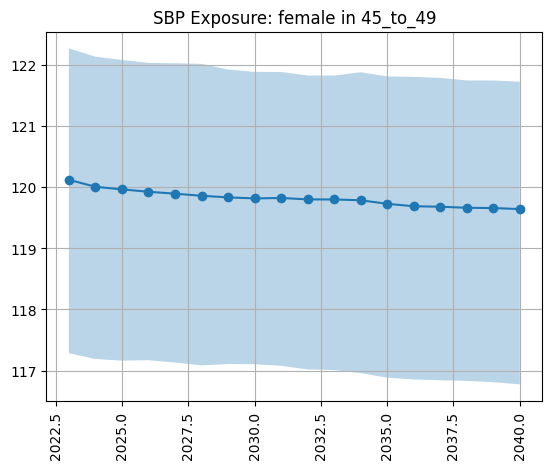

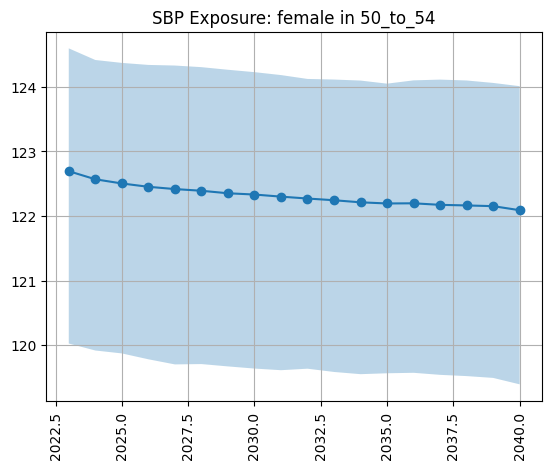

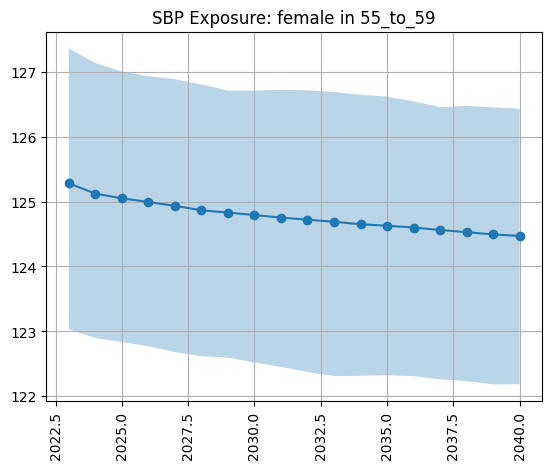

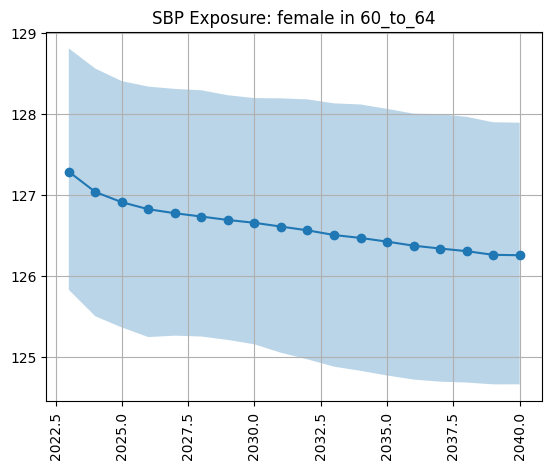

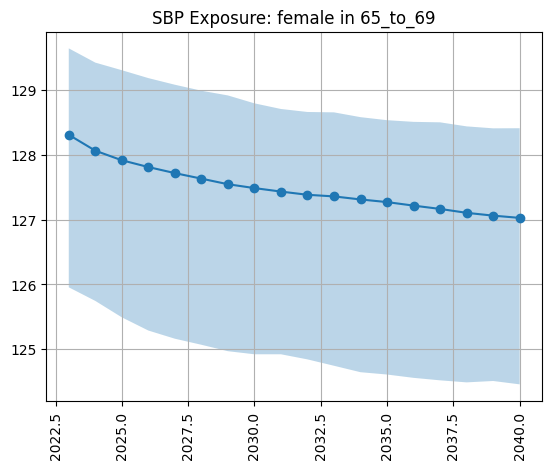

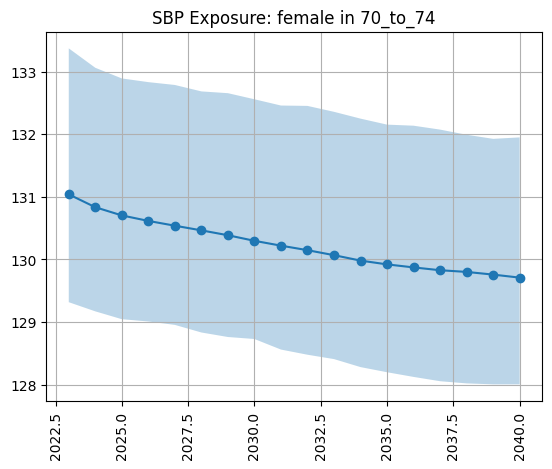

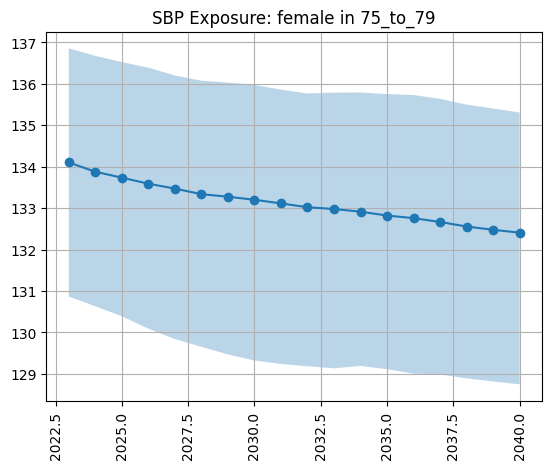

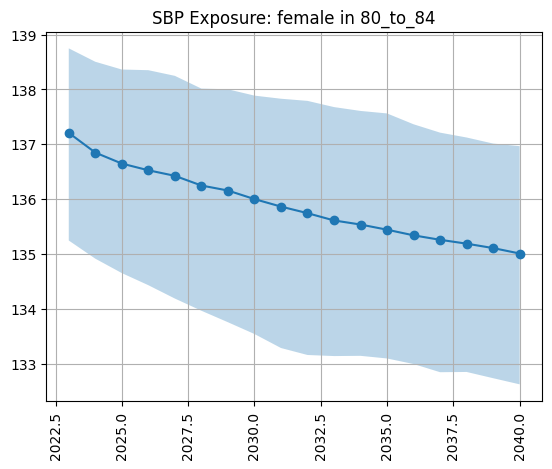

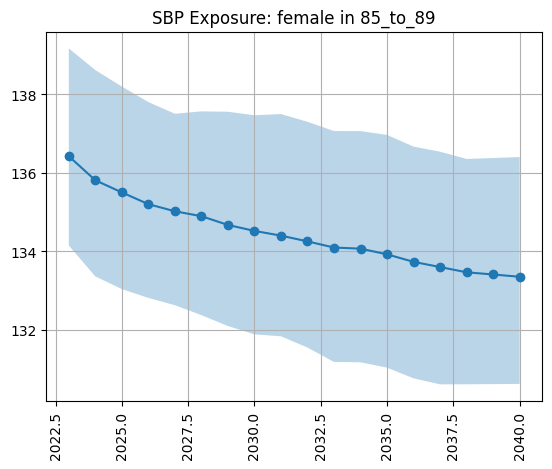

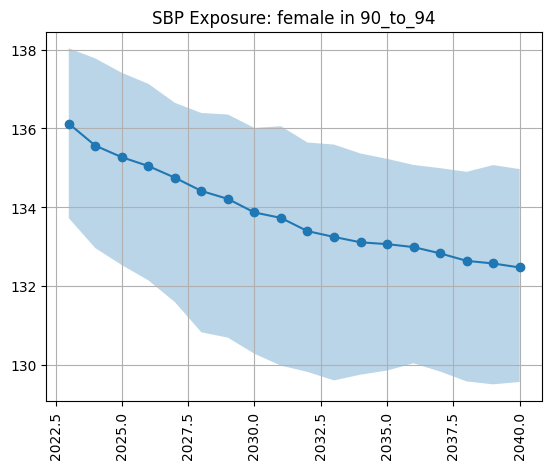

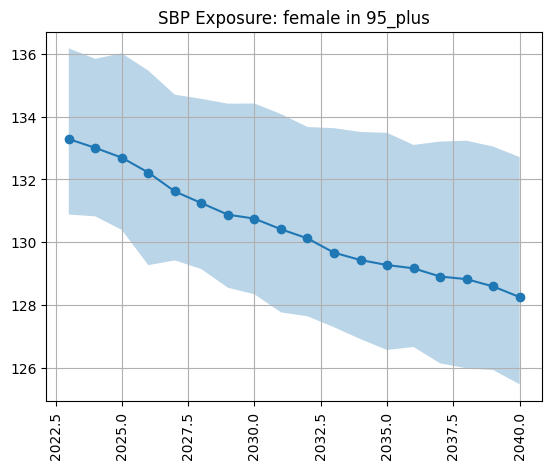

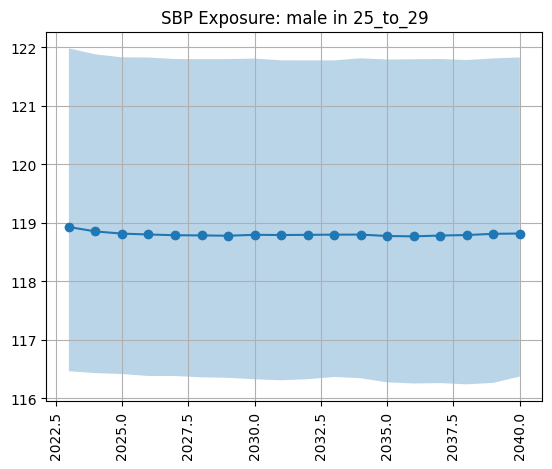

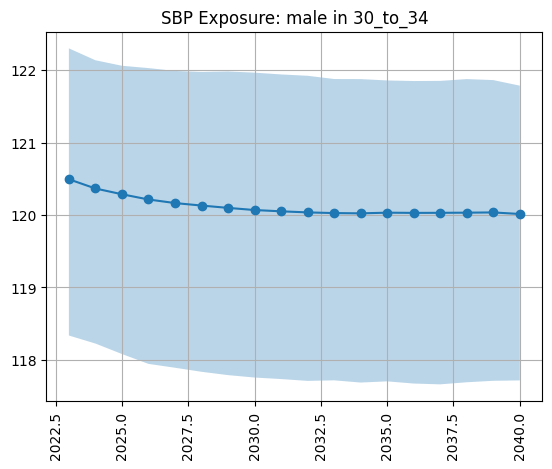

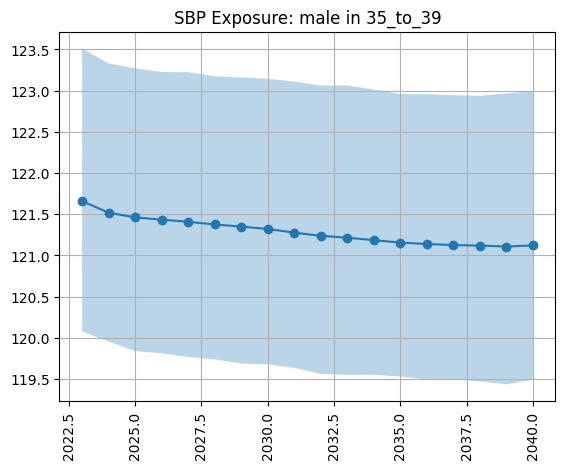

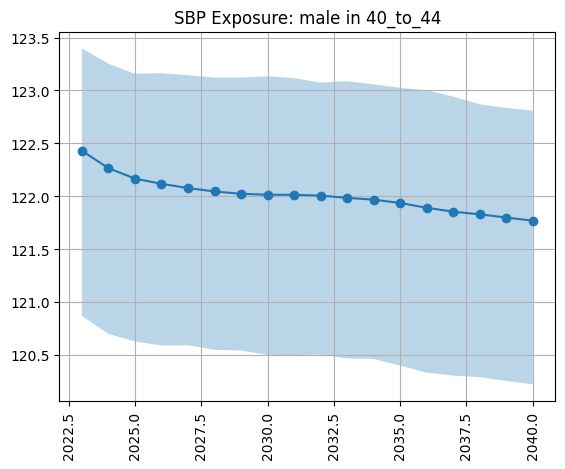

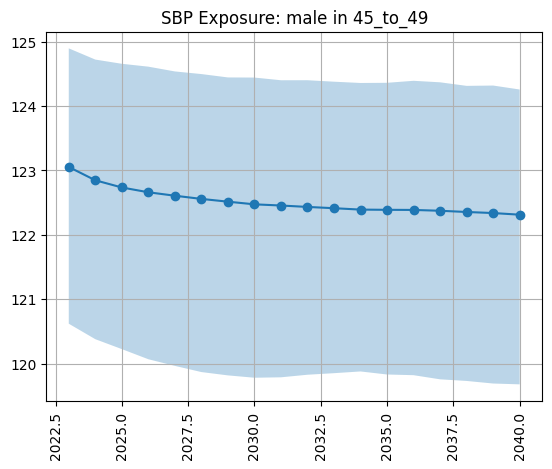

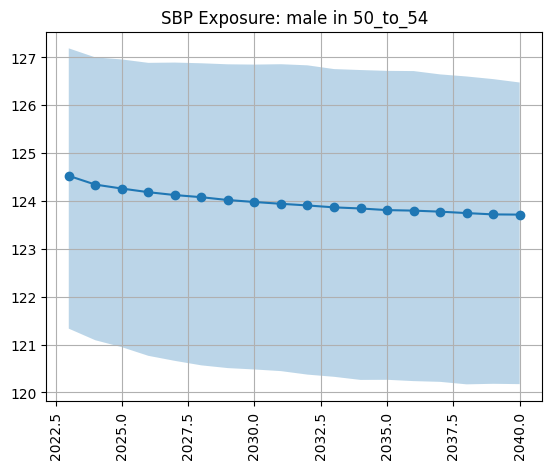

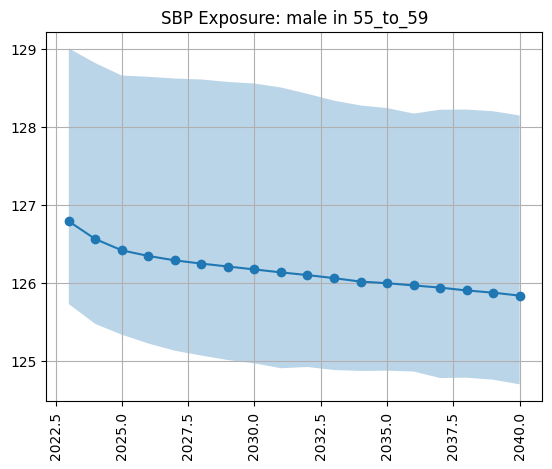

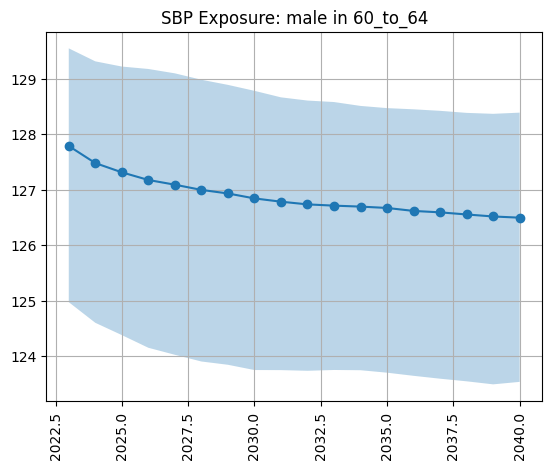

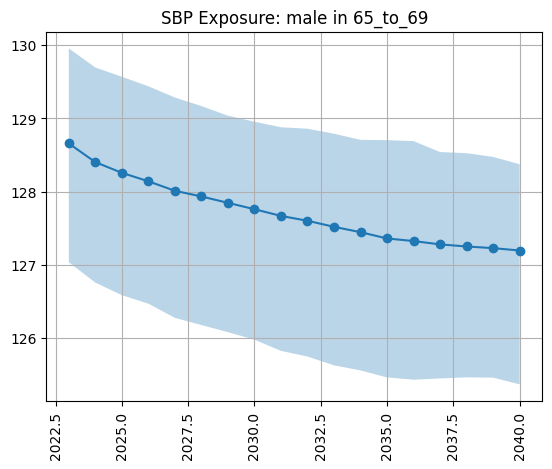

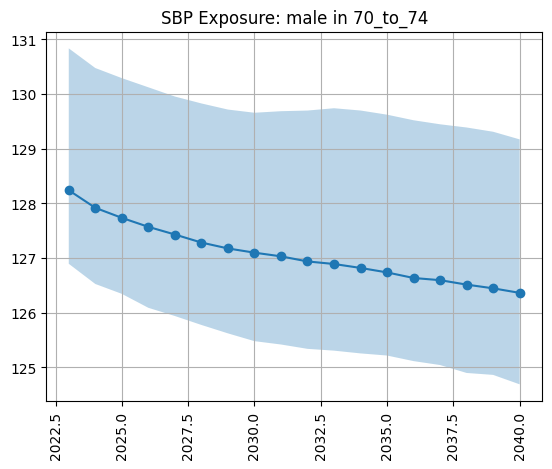

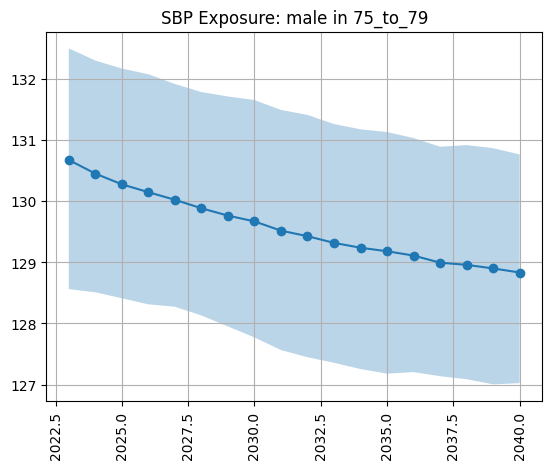

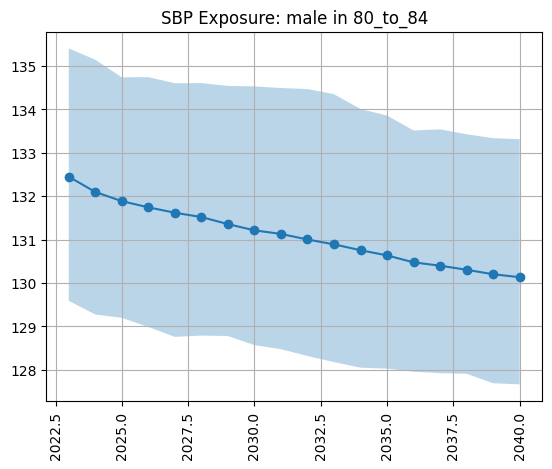

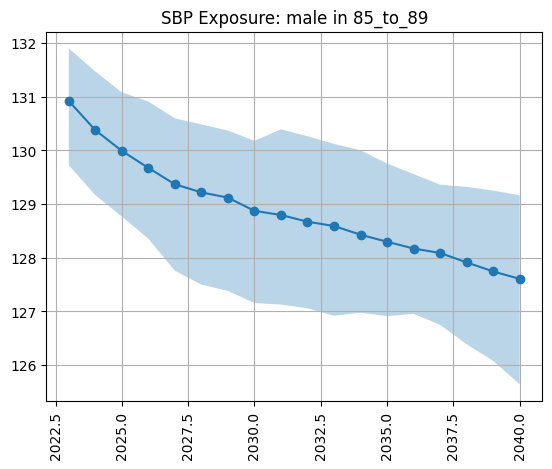

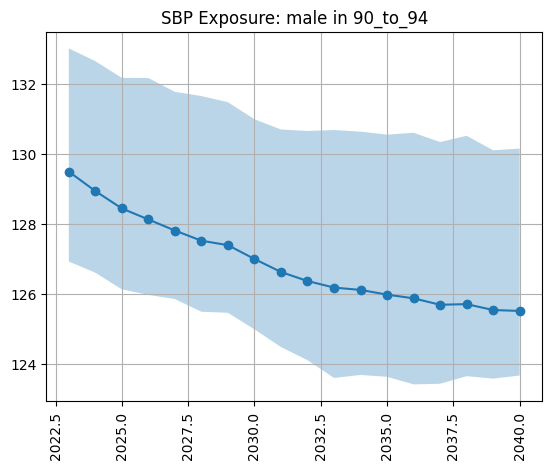

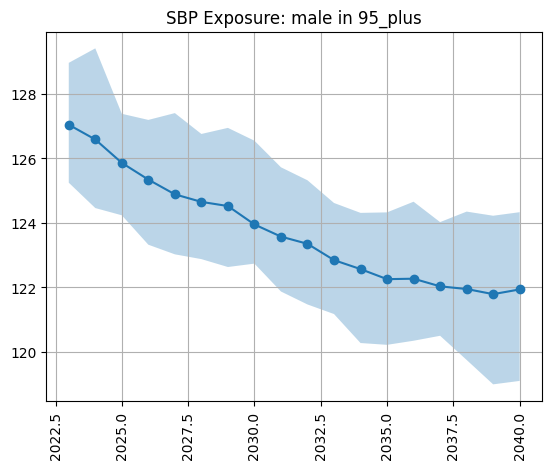

In [13]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [14]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.631696,2.556164,2.800967
1,25_to_29,female,2024,2.632159,2.559585,2.801749
2,25_to_29,female,2025,2.633864,2.559065,2.803759
3,25_to_29,female,2026,2.634405,2.559679,2.804460
4,25_to_29,female,2027,2.635611,2.559722,2.804515


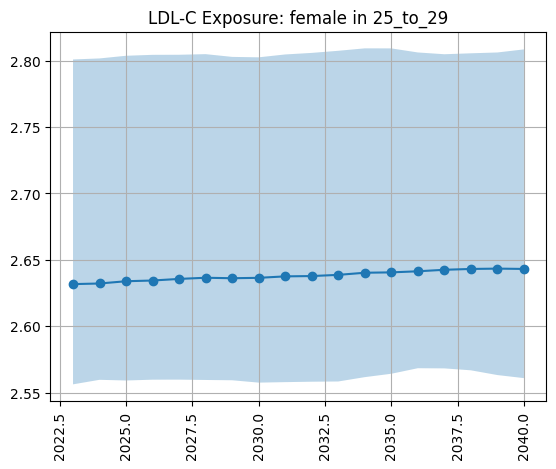

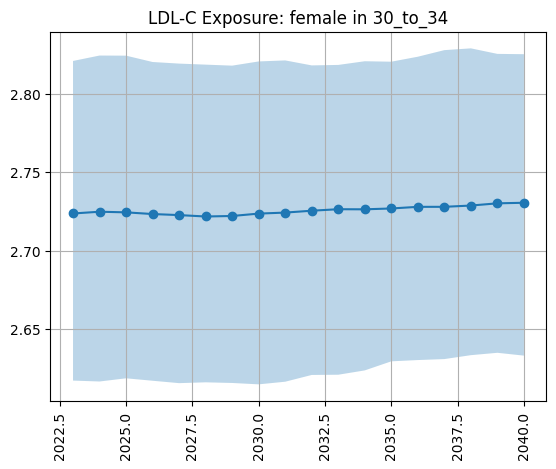

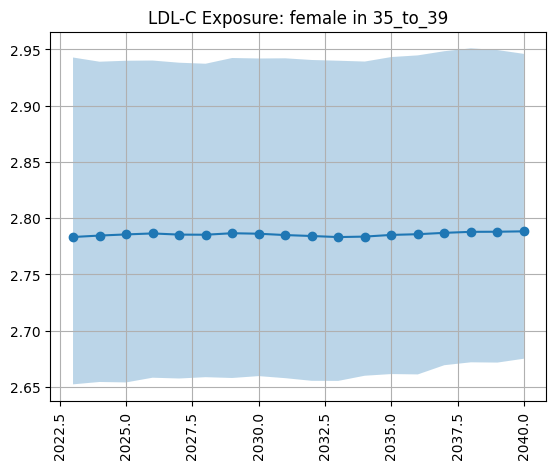

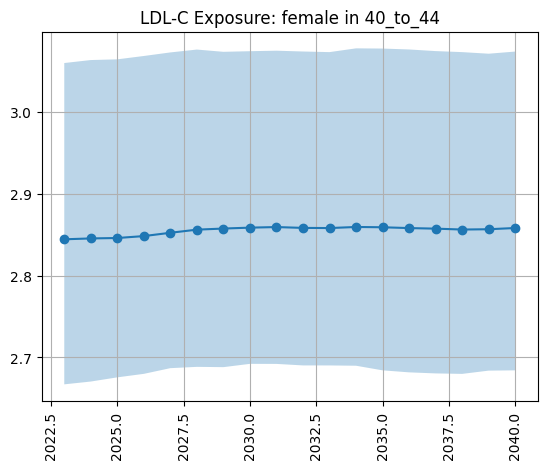

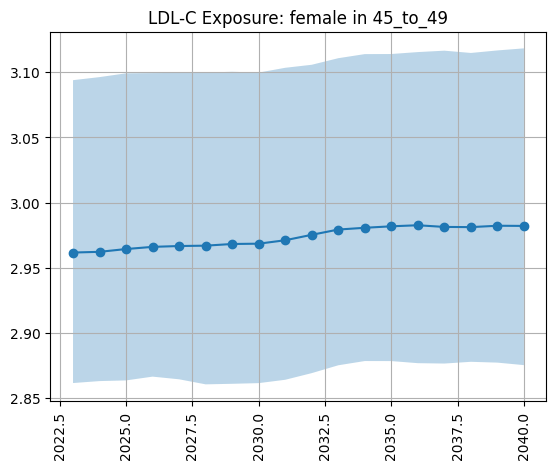

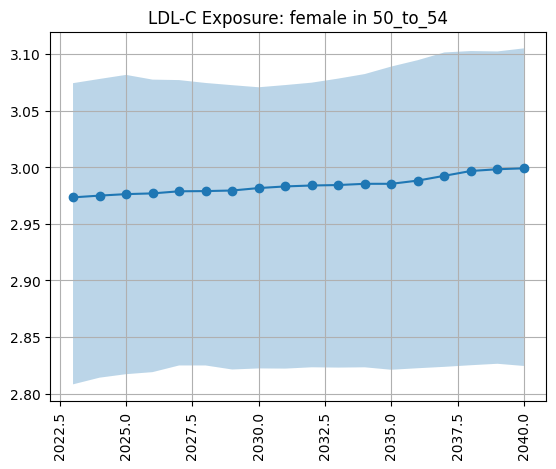

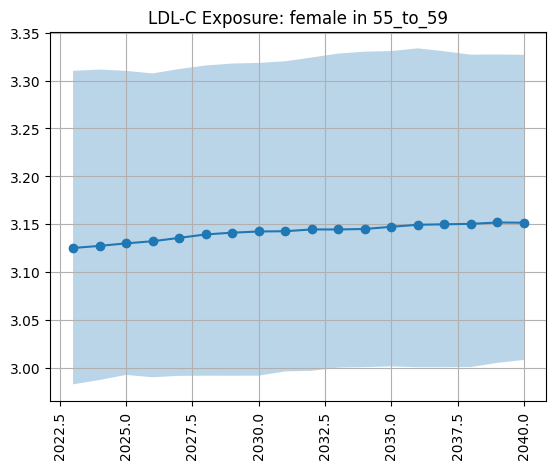

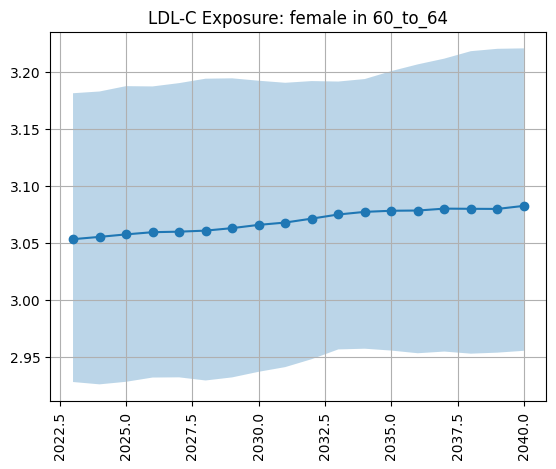

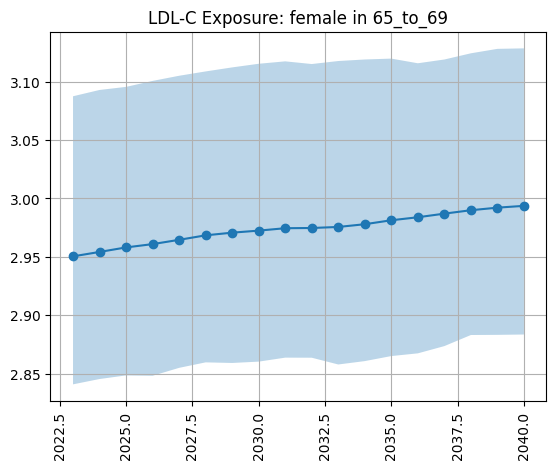

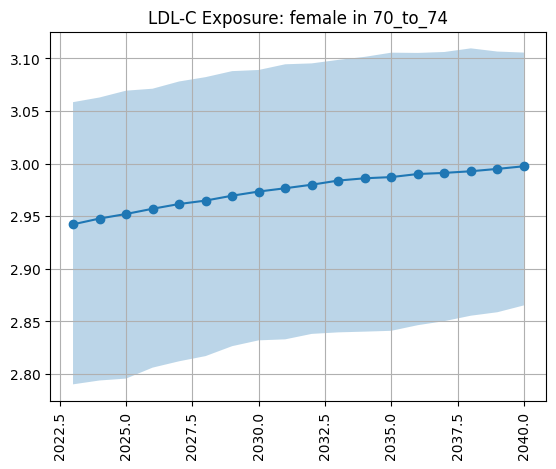

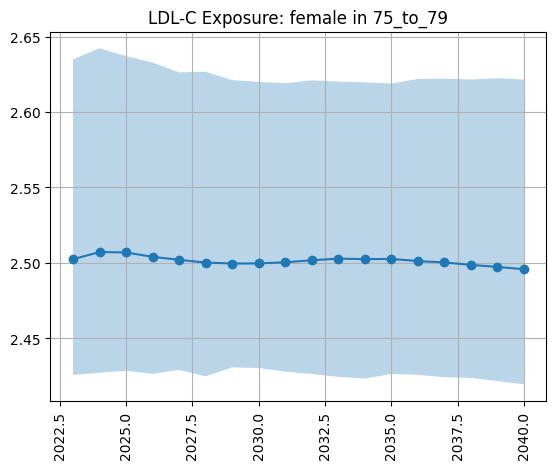

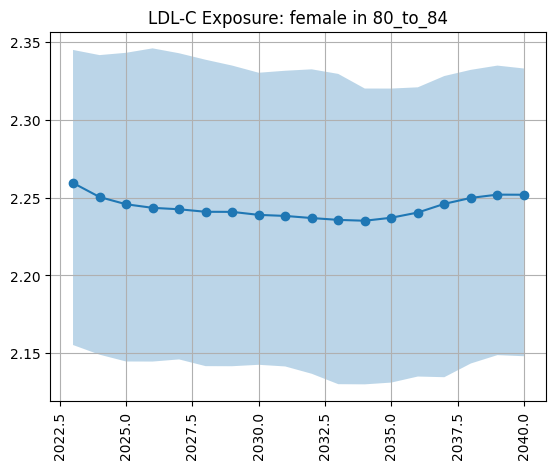

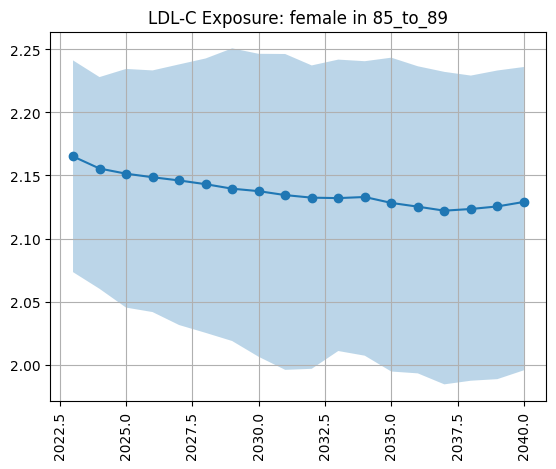

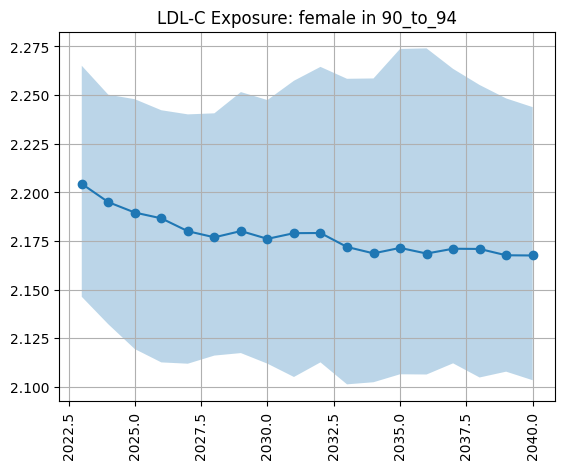

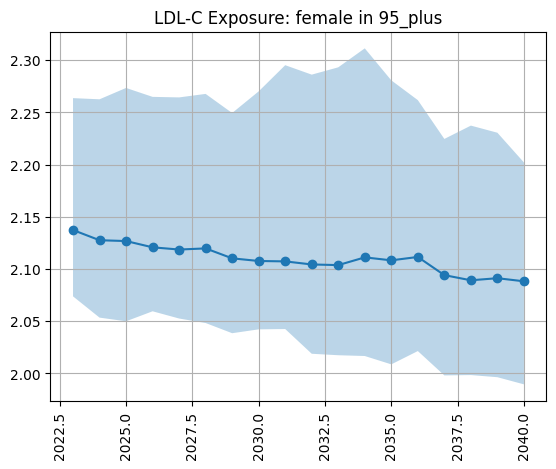

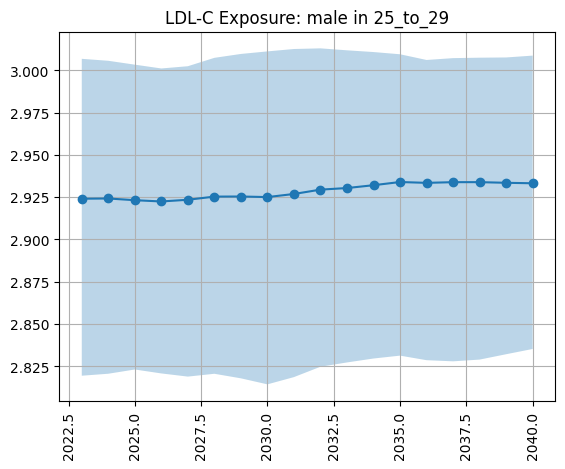

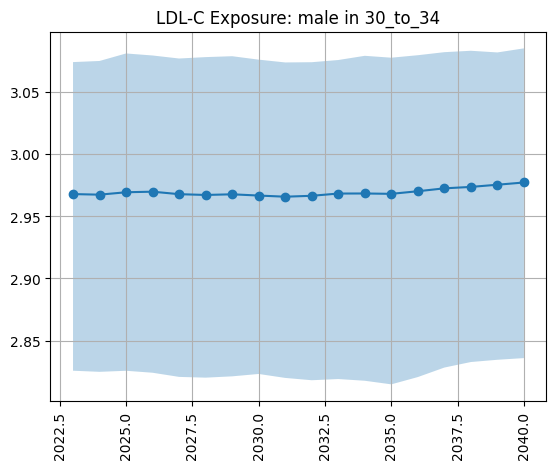

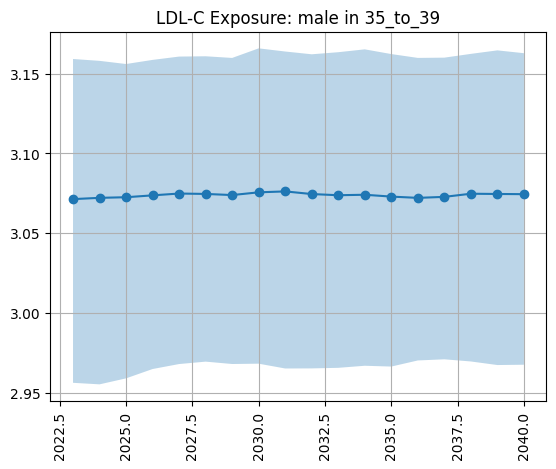

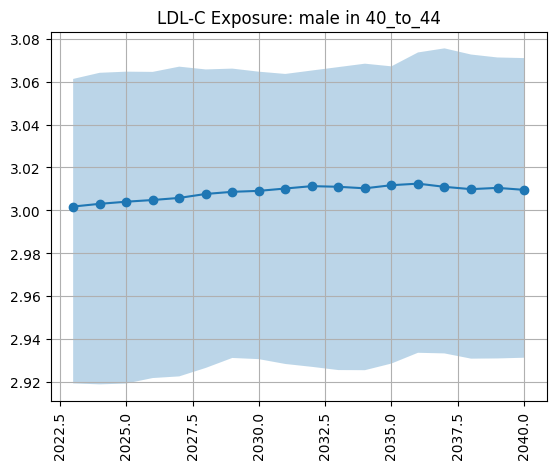

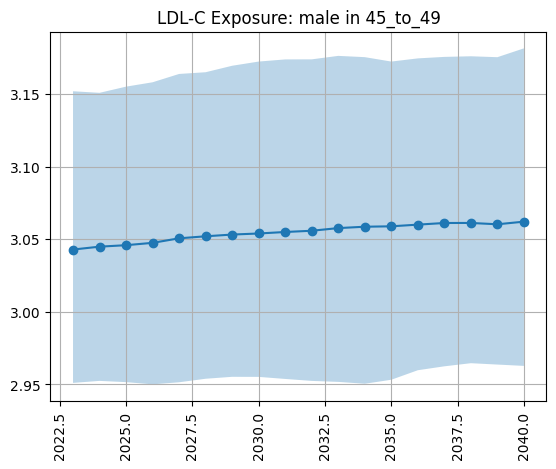

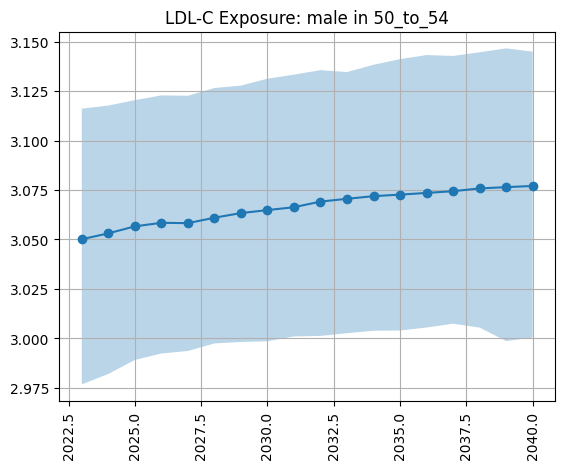

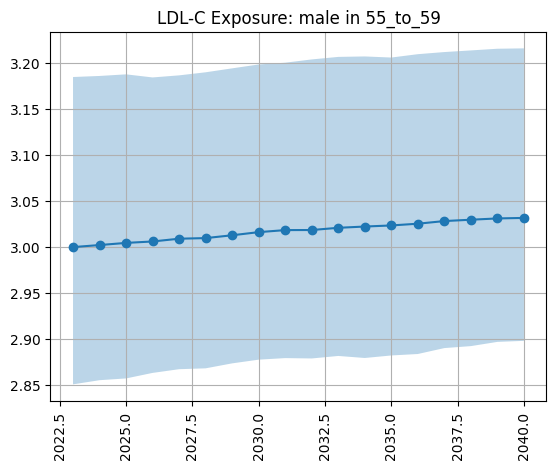

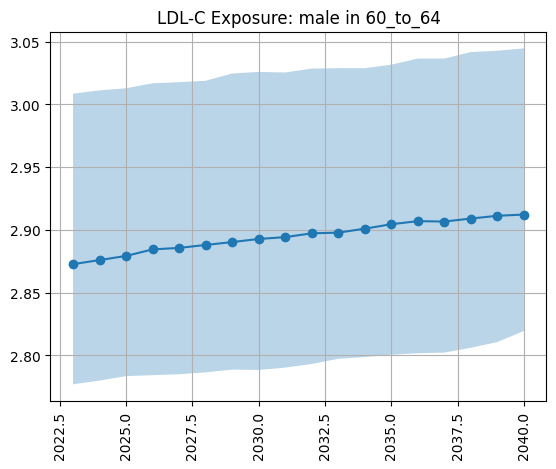

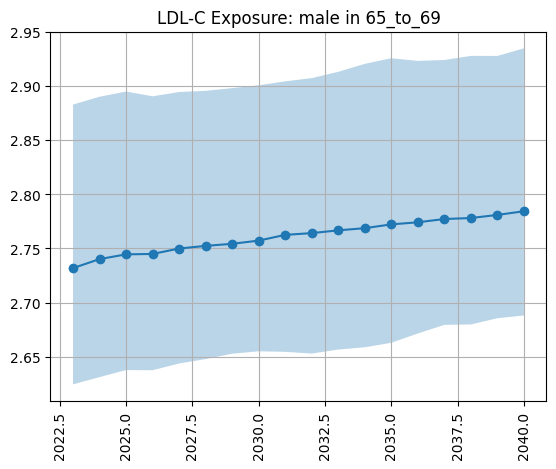

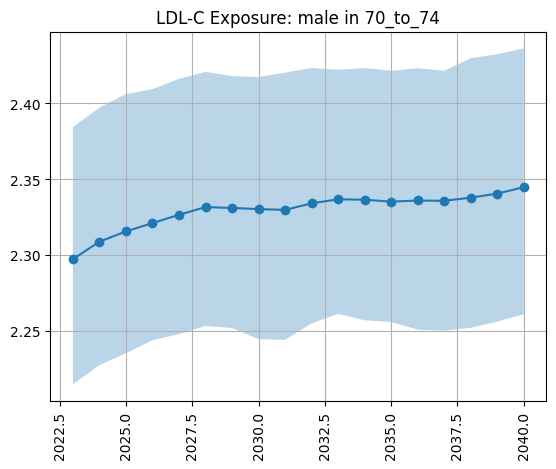

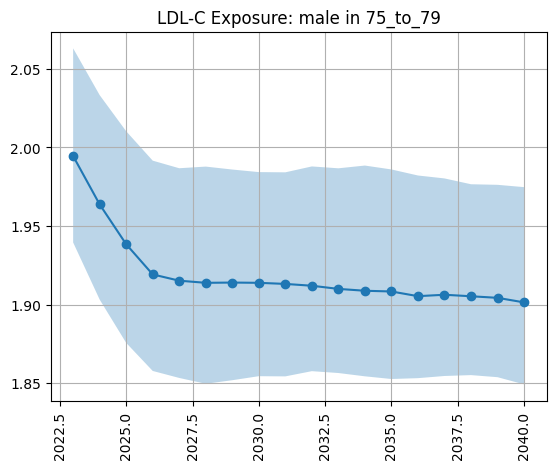

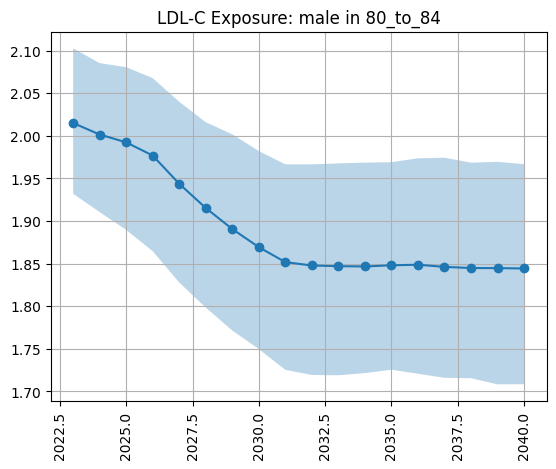

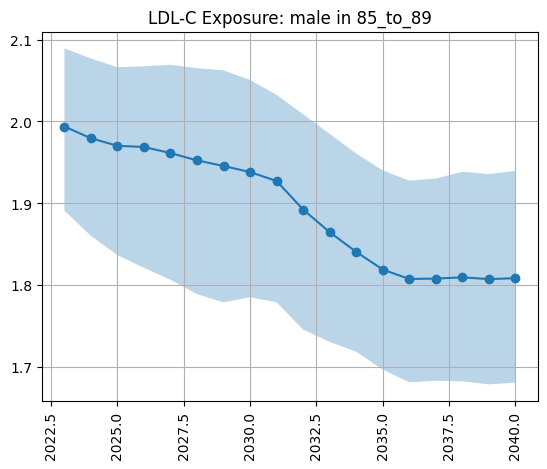

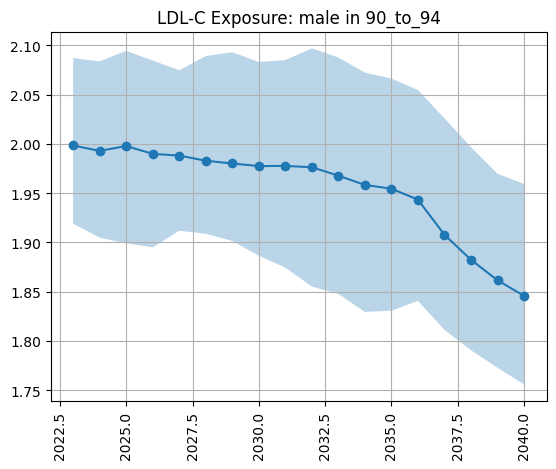

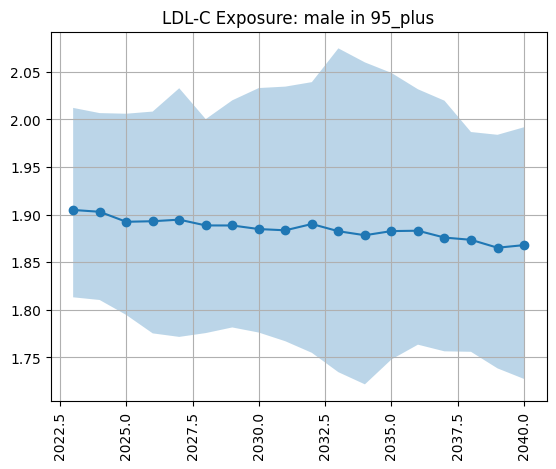

In [15]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [16]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,5.340931,4.840825,6.201330
1,25_to_29,female,2024,5.338992,4.842143,6.203101
2,25_to_29,female,2025,5.337284,4.842418,6.198071
3,25_to_29,female,2026,5.337620,4.840798,6.194397
4,25_to_29,female,2027,5.336985,4.842310,6.194204


In [17]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [18]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/  alabama_before_calculated_pafs.hdf  washington.hdf
alabama.hdf    raw_data/


In [19]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [20]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [21]:
#art.keys

In [22]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [23]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,30.899912,30.892990,30.572156,31.233780,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,31.636913,31.638236,31.293987,31.989474,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,31.883495,31.884883,31.555235,32.210906,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,32.130649,32.123262,31.801051,32.462829,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,32.169931,32.165649,31.855765,32.505542,Alabama,exposure,45_to_49


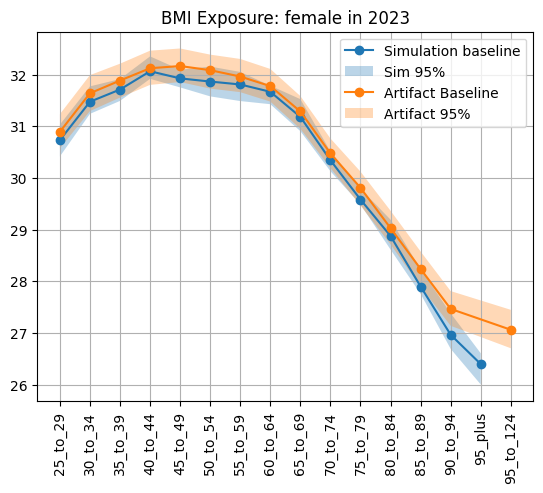

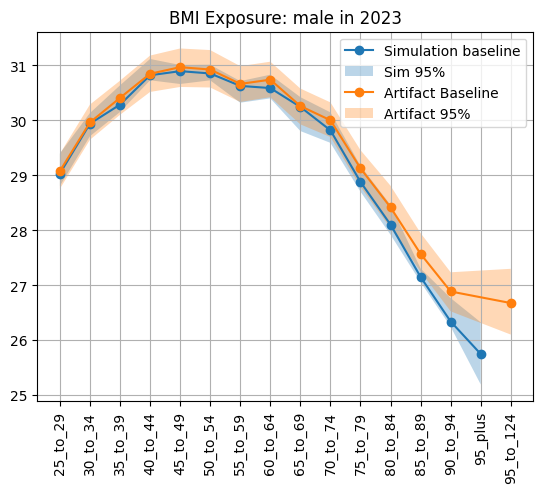

In [24]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

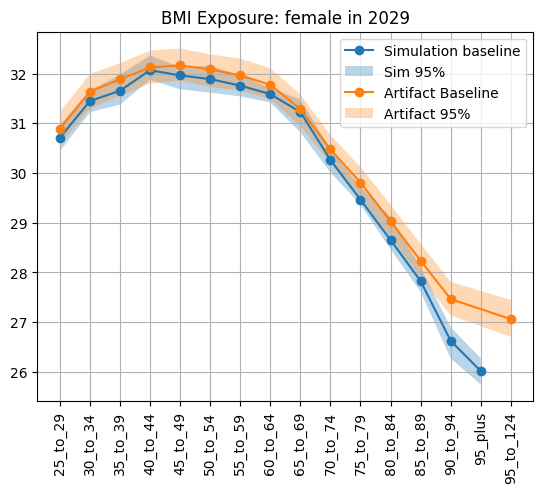

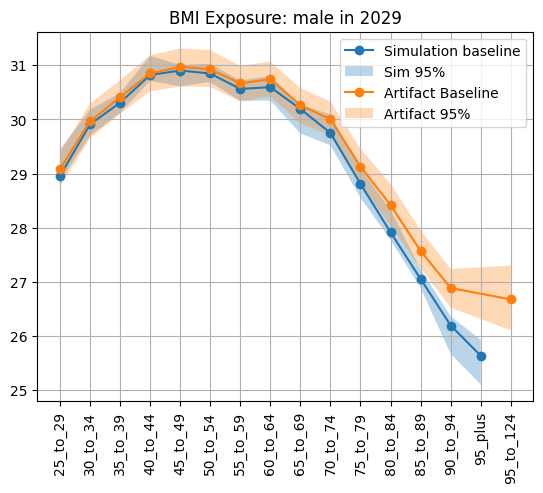

In [25]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2029)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2029') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [26]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,110.635893,110.623634,107.945700,113.550750,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,112.876275,112.881309,110.098198,115.523727,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,116.139886,116.134678,113.594023,118.770064,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,118.491616,118.514616,115.903577,121.039457,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,121.645391,121.618436,118.875235,124.529834,Alabama,exposure,45_to_49


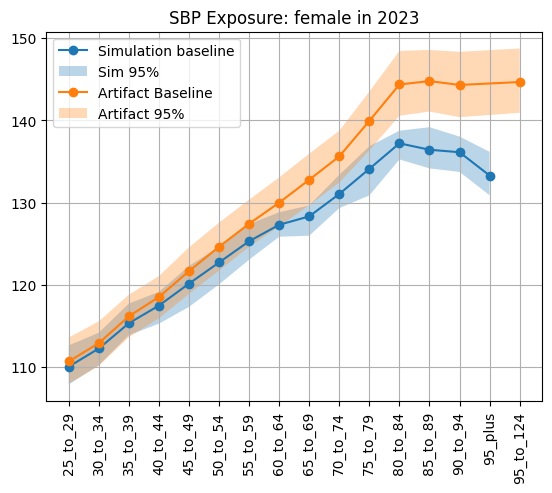

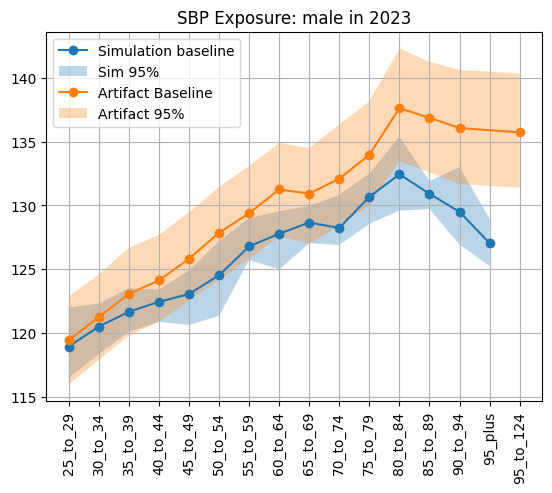

In [27]:
#Can we stratify by medication coverage? 

for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

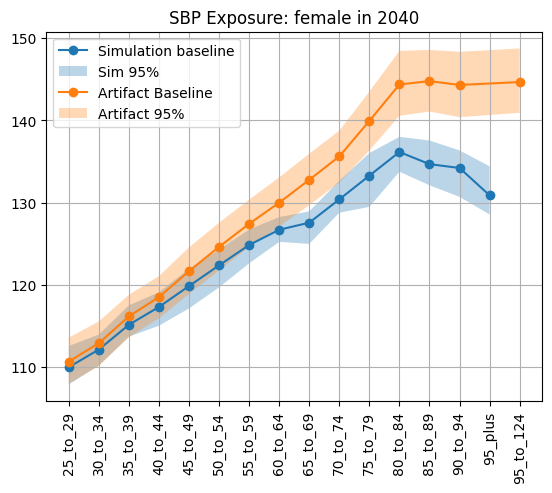

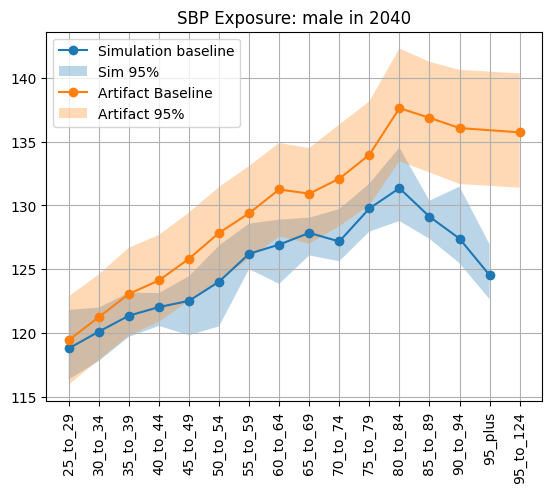

In [28]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [29]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.639862,2.638003,2.472574,2.821188,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.724353,2.723671,2.553736,2.905134,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.802925,2.801341,2.639513,2.972487,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.880791,2.878250,2.721814,3.039119,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.998297,2.995129,2.837974,3.175367,Alabama,exposure,45_to_49


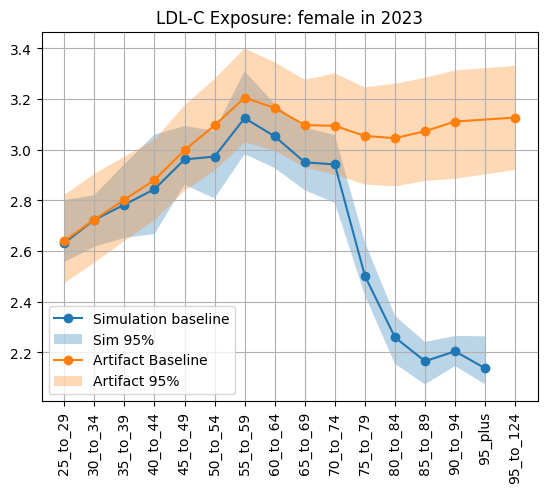

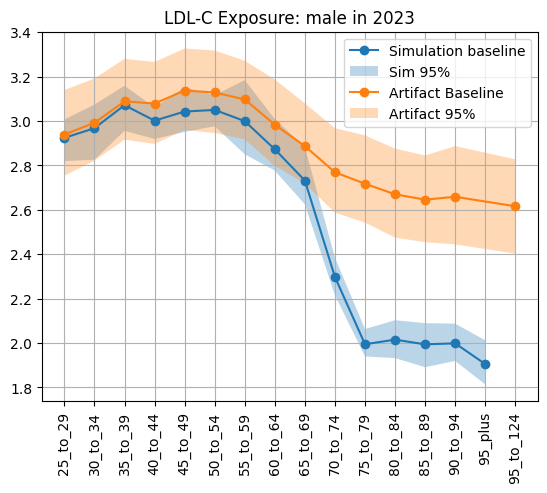

In [30]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

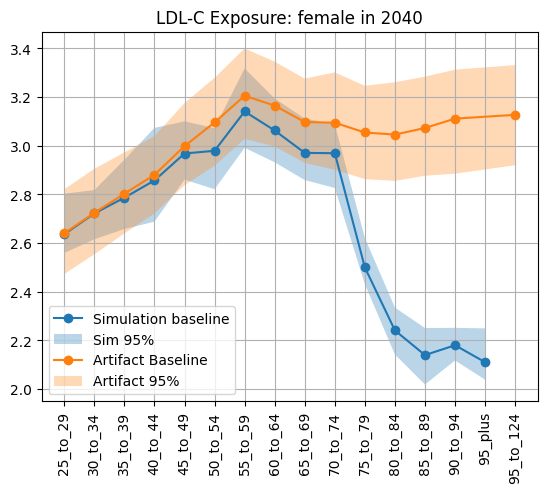

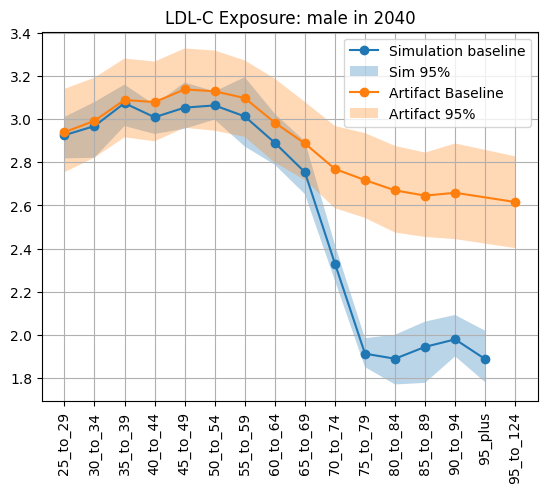

In [31]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [32]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,5.316303,5.307507,4.613215,6.137399,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,5.461718,5.447329,4.696085,6.297658,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,5.538952,5.538472,4.750516,6.371252,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,5.659873,5.650779,4.873814,6.494619,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,5.787248,5.771666,5.004493,6.682187,Alabama,exposure,45_to_49


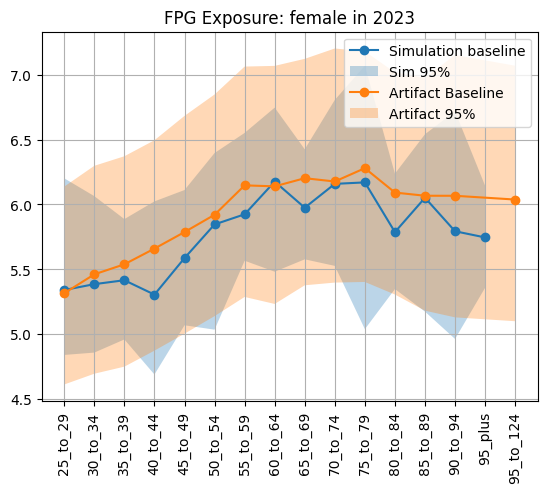

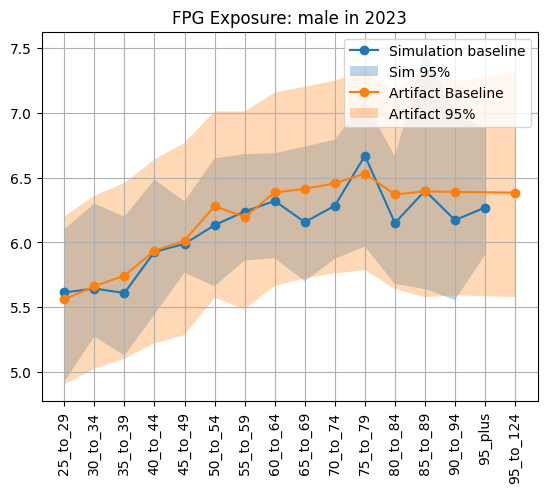

In [33]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

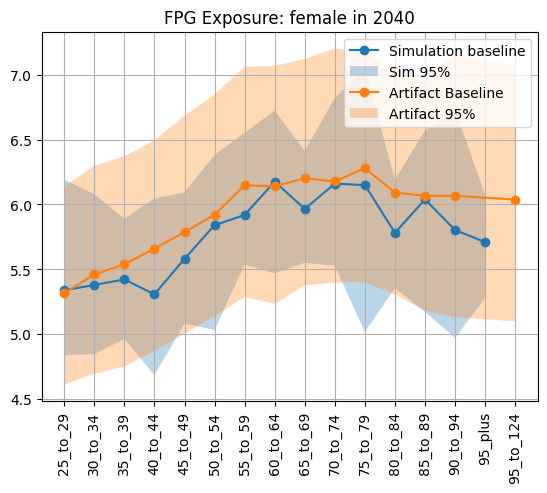

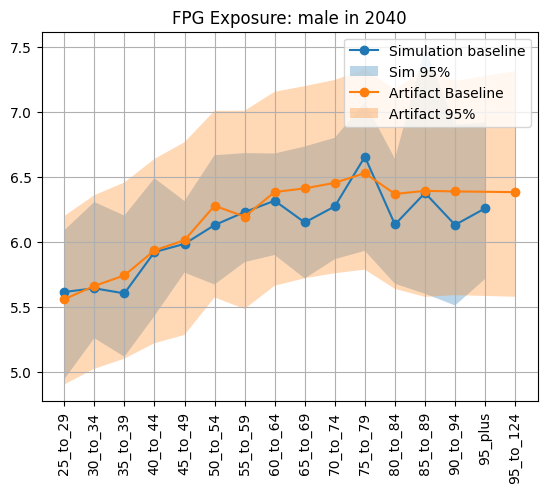

In [34]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad